Tutorial from: https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/ 

Aim: Use ML to predict the grade of diabetic retinopathy from a fundus image. Therefore a multi-class image classification problem. Solved by using a pre-trained model InceptionResNetV2, and customizing it.

InceptionResNetV2: is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

In [3]:
# Import

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


2023-08-31 09:55:11.574804: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 09:55:11.603312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 09:55:20.921127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
# Set up TODO update to UoA-DR

data_path = './data/UoA-DR/' 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test') 
label_path = os.path.join(data_path, 'UoA-DR-labels.csv')

labels = pd.read_csv(label_path)

x_name = "Image Number"
y_name = "Class"

labels.head()



# possible_labels = labels['Class'].unique()
# print(possible_labels)

,Image Number,Class,Healthy,NPDR,PDR
0,1,NPDR,0,1,0
1,2,NPDR,0,1,0
2,3,NPDR,0,1,0
3,4,NPDR,0,1,0
4,5,NPDR,0,1,0


In [20]:
# Custom functions 

def to_jpg(id):
    return str(id) + ".jpg"

# Convert the 'id' column to string type
labels[x_name] = labels[x_name].astype(str)
# Apply the to_jpg function
labels[x_name] = labels[x_name].apply(to_jpg)

labels.head()

,Image Number,Class,Healthy,NPDR,PDR
0,1.jpg,NPDR,0,1,0
1,2.jpg,NPDR,0,1,0
2,3.jpg,NPDR,0,1,0
3,4.jpg,NPDR,0,1,0
4,5.jpg,NPDR,0,1,0


In [21]:
# Data agumentation and pre-processing

rescale_factor = 1./255.
has_horizontal_flip = True
validation_split = 0.2 # training: 80% data, validation: 20% data
batch_size = 32
has_shuffle = True
seed = 42

gen = ImageDataGenerator(
				rescale= rescale_factor,
				horizontal_flip = has_horizontal_flip,
				validation_split= validation_split 
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="training",
	color_mode="rgb",
	target_size = (331,331), # image height , image width
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="validation",
	color_mode="rgb",
	target_size = (331,331), # image height , image width
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size



Found 130 validated image filenames belonging to 3 classes.
Found 32 validated image filenames belonging to 3 classes.


(32, 331, 331, 3)

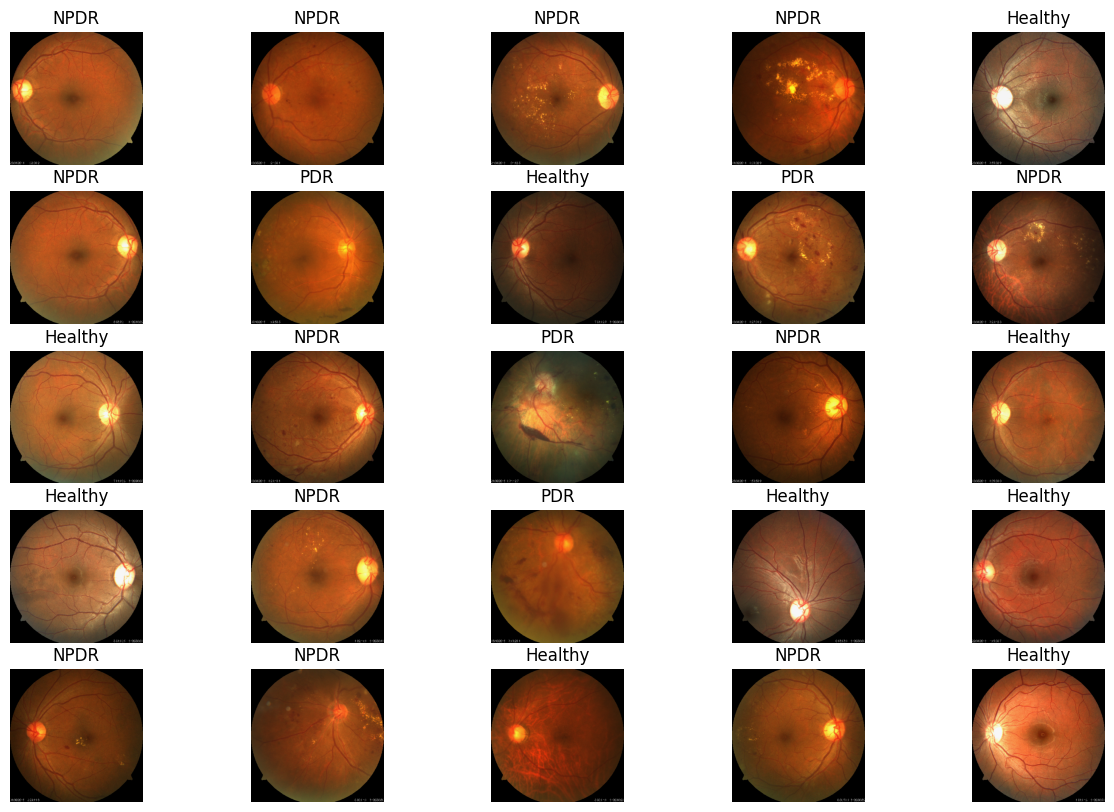

In [23]:
# Plot images

a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list


def plot_images(img, labels):
	plt.figure(figsize=[15, 10])
	for i in range(25):
		plt.subplot(5, 5, i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
		plt.axis('off')

plot_images(x,y)


In [24]:
# Build model

# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(120, activation='softmax')
	])


2023-08-31 10:34:31.904497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 10:34:31.944028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 10:34:31.944163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [25]:
# Compile model

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (

In [26]:
# Defining callbacks to preserve the best results

early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back


In [27]:
# Train model

batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=25,
					callbacks=[early])


Epoch 1/25


2023-08-31 10:36:08.755687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-31 10:36:09.376548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/csse/users/yyu69/miniconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/csse/users/yyu69/miniconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/csse/users/yyu69/miniconda3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1696322/2985178038.py", line 8, in <module>
      history = model.fit(train_generator,
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[2,120] labels_size=[2,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_34818]

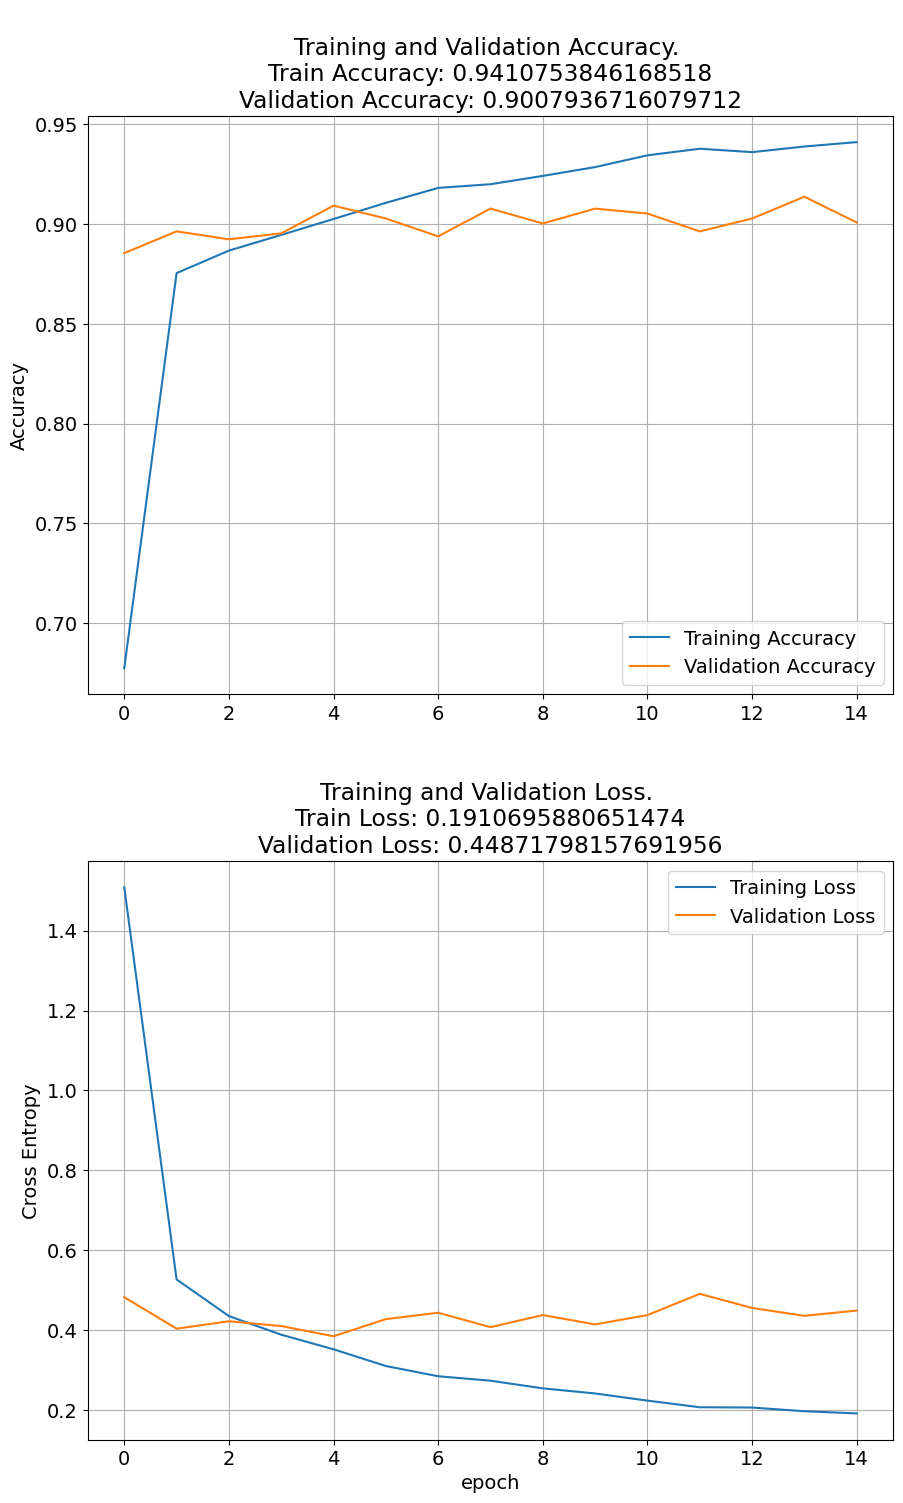

In [35]:
# Visualize model

# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [36]:
# Evaluate model

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


64/64 [==============================] - 19s 251ms/step - loss: 4.7941 - accuracy: 0.0068
[4.794098377227783, 0.006849315017461777]
Accuracy: 0.6849%
Loss:  4.794098377227783


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_407 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

In [50]:
print(possible_labels)

['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 'mexican_h

1/1 [==============================] - 0s 20ms/step
[[0.00846976 0.00983847 0.00760132 0.00799227 0.00730697 0.00901215
  0.0071142  0.0087349  0.00765774 0.00768061 0.0085269  0.00903351
  0.00776732 0.00825412 0.00713995 0.00991586 0.00858323 0.00836736
  0.0080174  0.00835431 0.00943747 0.00791262 0.00837323 0.01023216
  0.00811736 0.0089915  0.00816469 0.01045208 0.00906987 0.00882139
  0.00776996 0.01016747 0.00849277 0.00912482 0.0087076  0.00835046
  0.00924659 0.00661766 0.00744748 0.00825296 0.00922181 0.00839307
  0.00828162 0.00907096 0.00648359 0.00775161 0.00759617 0.00981023
  0.00935461 0.00878839 0.00847694 0.00825685 0.00977372 0.00976151
  0.00766295 0.01010241 0.00785909 0.0069727  0.00841386 0.00844862
  0.00839754 0.00769126 0.00902366 0.00797259 0.00809578 0.00798741
  0.00821183 0.00929351 0.00712442 0.00877807 0.00752739 0.00755255
  0.00944219 0.00779135 0.00761536 0.00943166 0.00882643 0.00889562
  0.00926765 0.00953584 0.00802541 0.00750049 0.00697133 0.00774

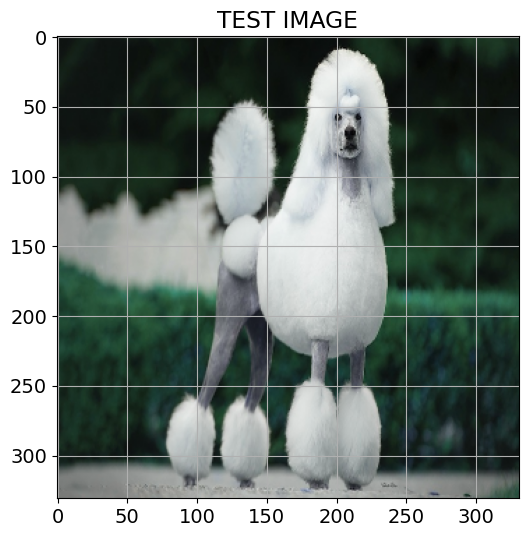

In [49]:
test_img_path = "Diana-the-Poodle.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])


img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

print(prediction)

# # Assuming your class labels are stored in a list called 'class_labels'
# class_labels = ["class1", "class2", "class3", ...]

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

# # Get the predicted class label using the index
# predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", possible_labels[predicted_class_index])



In [38]:
predictions = []

for image in sample.id:
	img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
	img = tf.keras.preprocessing.image.img_to_array(img)
	img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
	img = tf.reshape(img, (-1, 331, 331, 3))
	prediction = model.predict(img/255)
	predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': sample.id, 'label': predictions})
my_submission.to_csv('submission.csv', index=False)

# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output


NameError: name 'sample' is not defined

In [39]:
# Save model

model.save("Model.h5")
